In [5]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from datetime import datetime, date
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
SEED = 1
EPOCHS = 32
BATCH_SIZE = 64
NUM_CLASSES = 2
VERBOSE_LEVEL = 1
LEARNING_RATE = 1e-4
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

CWD = os.getcwd()
AUTOTUNE = tf.data.experimental.AUTOTUNE

GOOGLE_COLAB = False
if CWD == "/content":
    GOOGLE_COLAB = True

print ('Running in colab:', GOOGLE_COLAB)


Running in colab: False


In [80]:
def seed_all(seed):
    ''' A function to seed everything for getting reproducible results. '''
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = str(seed)
    os.environ['TF_KERAS'] = str(seed)
    tf.random.set_seed(seed)
    
seed_all(1)

In [13]:
DEVICE = 'TPU'
MIXED_PRECISION = True
XLA_ACCELERATE = True
GPUS = 0


tf.keras.backend.clear_session()

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# We set our TPU settings here mixed_precision loet's us bigger batches
if DEVICE == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
        print('Running on TPU ', tpu.master())
    except ValueError:
        print('Could not connect to TPU')
        tpu = None

    if tpu:
        try:
            print('initializing  TPU ...')
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.TPUStrategy(tpu)            
            print('TPU initialized')
            if MIXED_PRECISION:
                from tensorflow.keras.mixed_precision import experimental as mixed_precision
                policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
                mixed_precision.set_policy(policy)
                print('Mixed precision enabled')
            if XLA_ACCELERATE:
                    tf.config.optimizer.set_jit(True)
                    print('Accelerated Linear Algebra enabled')
                 
        except _:
            print('failed to initialize TPU')
    else:
        DEVICE = 'GPU'

if DEVICE != 'TPU':
    print('Using default strategy for CPU and single GPU')
    strategy = tf.distribute.get_strategy()

if DEVICE == 'GPU':
    GPUS = len(tf.config.experimental.list_physical_devices('GPU'))
    print('Num GPUs Available: ', GPUS)
    if MIXED_PRECISION:
        from tensorflow.keras.mixed_precision import experimental as mixed_precision
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        print('Mixed precision enabled')
    if XLA_ACCELERATE:
        tf.config.optimizer.set_jit(True)
        print('Accelerated Linear Algebra enabled')

if DEVICE != 'TPU' and GPUS == 0:
    DEVICE = 'CPU'
    

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
STRATEGY = strategy

# Update BATCH_SIZE
BATCH_SIZE = BATCH_SIZE * REPLICAS

print("REPLICAS", REPLICAS)
print("DEVICE", DEVICE)

Could not connect to TPU
Using default strategy for CPU and single GPU
Num GPUs Available:  0
The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Mixed precision enabled
Accelerated Linear Algebra enabled
REPLICAS 1
DEVICE CPU


In [9]:
base_path = '/kaggle/input/siim-isic-melanoma-classification'
path_to_images = '/kaggle/input/siim-isic-melanoma-classification/jpeg' 
image_type = ".jpg"

# check on which system we are
if os.path.exists(CWD + '/data'):
    base_path = os.path.join(CWD, 'data')
    path_to_images = base_path
    image_type = ".png"
    print("change base_path to ", base_path)

if GOOGLE_COLAB:
    CWD = "/content/melanoma-classification"
    base_path = os.path.join(CWD, 'data')
    path_to_images = base_path
    image_type = ".png"
    print("change base_path to ", base_path)

train = pd.read_csv(os.path.join(base_path, 'train.csv'))
test = pd.read_csv(os.path.join(base_path, 'test.csv'))

change base_path to  /workspaces/melanoma-classification/data


In [83]:
# add the image_path
train['image_path'] = train['image_name'].apply(lambda x: path_to_images + "/train/" + x + image_type)
test['image_path'] = test['image_name'].apply(lambda x: path_to_images + "/test/" + x + image_type)

# getting dummy variables for gender
sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex', dtype="int")
test = pd.concat([test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)

anatom_dummies = pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
test = pd.concat([test, anatom_dummies], axis=1)

# dropping not useful columns
train.drop(['sex','image_name','diagnosis','benign_malignant','anatom_site_general_challenge'], axis=1, inplace=True)
test.drop(['sex','image_name','anatom_site_general_challenge'], axis=1, inplace=True)

# replace missing age values wiht the mean age
train['age_approx'] = train['age_approx'].fillna(int(np.mean(train['age_approx'])))
test['age_approx'] = test['age_approx'].fillna(int(np.mean(test['age_approx'])))

# convert age to int
train['age_approx'] = train['age_approx'].astype('int')
test['age_approx'] = test['age_approx'].astype('int')

In [84]:
train.dtypes

patient_id                object
age_approx                 int64
target                     int64
image_path                object
sex_female                 int64
sex_male                   int64
anatom_head/neck           int64
anatom_lower extremity     int64
anatom_oral/genital        int64
anatom_palms/soles         int64
anatom_torso               int64
anatom_upper extremity     int64
dtype: object

In [85]:
# reduce the df and batch size when running on a cpu
if DEVICE == 'CPU':
    print("reduce df size and epochs")
    train = train.head(500)
    test = test.head(500)
    EPOCHS = 3

reduce df size and epochs


In [86]:
train_df, val_df = train_test_split(train, test_size=0.2, stratify=train['target'])

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# Get a balanced dataset (50/50) = equal amount of positive and negative cases in Training
p_inds = train_df[train_df.target == 1].index.tolist()
np_inds = train_df[train_df.target == 0].index.tolist()

np_sample = random.sample(np_inds, len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
print("samples in train", train_df['target'].sum()/len(train_df))

# Get a validation set with at 20% positive cases
p_inds = val_df[val_df.target == 1].index.tolist()
np_inds = val_df[val_df.target == 0].index.tolist()

np_sample = random.sample(np_inds, 4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]
print("samples in validation", val_df['target'].sum()/len(val_df))

test_df = test
print("rows in test_df", test_df.shape[0])

rows in train_df 400
rows in val_df 100
samples in train 0.5
samples in validation 0.2
rows in test_df 500


In [87]:
## prepare images for training
train_idg = ImageDataGenerator(
    rescale=1 / 255.0,
    horizontal_flip=True,
    vertical_flip=True,
)

train_gen = train_idg.flow_from_dataframe(
    seed=SEED,
    dataframe=train_df,
    directory=None,
    x_col='image_path',
    y_col='target',
    class_mode='raw',
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 10 validated image filenames.


In [88]:
## prepare images for validation
val_idg = ImageDataGenerator(rescale=1. / 255.0)
val_gen = val_idg.flow_from_dataframe(
    seed=SEED,
    dataframe=val_df,
    directory=None,
    x_col='image_path',
    y_col='target',
    class_mode='raw',
    shuffle=False,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 5 validated image filenames.


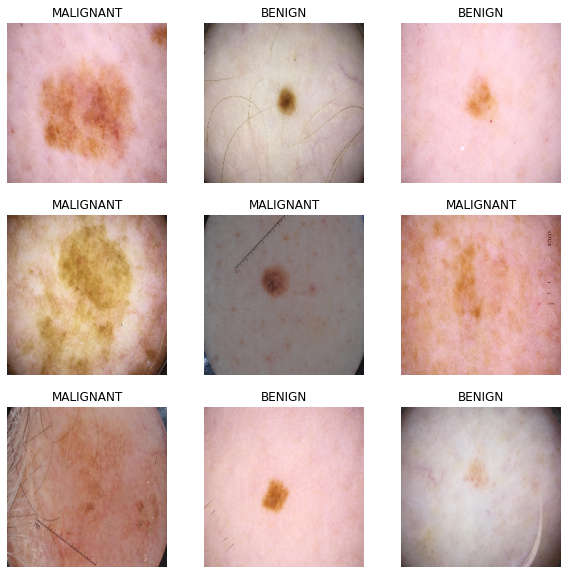

In [89]:
images, labes = next(train_gen)
plt.figure(figsize=(10, 10))
counter = 0

for image in images[:9]:
    ax = plt.subplot(3, 3, counter + 1)
    plt.imshow(image)
    plt.axis("off")
    if labes[counter] == 1: 
        plt.title('MALIGNANT')
    else:
        plt.title('BENIGN')
    counter = counter + 1

In [90]:
def save_history(history, timestamp):
    """Helper function to save a png image of the loss and accuracy
    Args:
        history ([tf history]): The history object of a tf model
    """
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    plt.savefig("./" + timestamp + "-history.png")

def get_prediction(img_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img = tf.expand_dims(img, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    score = score.numpy()
    return score[1]

In [91]:
def create_model():
    model = Sequential([
      layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(INPUT_SHAPE)),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(NUM_CLASSES)
    ])
    return model

In [92]:
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

weight_path = "./" + timestamp + "-model.hdf5"

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=VERBOSE_LEVEL,
    save_best_only=True,
    mode='auto',
    save_weights_only=True,
    overwrite=True
)

early = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
callbacks_list = [checkpoint, early]

In [ ]:
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

# To begin training, construct the model on the TPU and then compile it.
if STRATEGY:
    with strategy.scope():
        model = create_model()
        model.compile(
            optimizer=OPTIMIZER,
            loss=LOSS,
            metrics=METRICS,
        )
else:
    model = create_model()
    model.compile(
        optimizer=OPTIMIZER,
        loss=LOSS,
        metrics=METRICS,
    )

In [93]:
history = model.fit(
    train_gen, 
    validation_data=(val_gen.next()), 
    epochs=EPOCHS, 
    callbacks=callbacks_list, 
    verbose=VERBOSE_LEVEL
)

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 1.9805 - accuracy: 0.5000
Epoch 00001: val_loss improved from inf to 0.59570, saving model to ./2020-12-22_09:50:36-model.hdf5
1/1 [==============================] - 1s 1s/step - loss: 1.9805 - accuracy: 0.5000 - val_loss: 0.5957 - val_accuracy: 0.6000
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 1.8867 - accuracy: 0.5000
Epoch 00002: val_loss did not improve from 0.59570
1/1 [==============================] - 1s 741ms/step - loss: 1.8867 - accuracy: 0.5000 - val_loss: 1.5244 - val_accuracy: 0.8000
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.9648 - accuracy: 0.5000
Epoch 00003: val_loss did not improve from 0.59570
1/1 [==============================] - 0s 473ms/step - loss: 0.9648 - accuracy: 0.5000 - val_loss: 5.6016 - val_accuracy: 0.2000


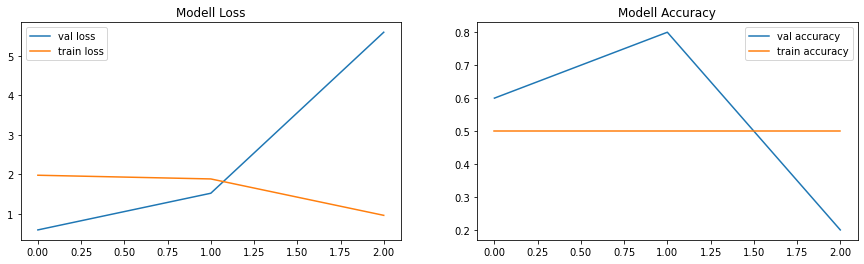

In [94]:
save_history(history, timestamp)

model_json = model.to_json()
with open("./" + timestamp + "-model.json", "w") as json_file:
    json_file.write(model_json)

In [95]:
image_path = test_df.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

% BENIGN 0.3916
% MALIGNANT 0.609


(-0.5, 223.5, 223.5, -0.5)

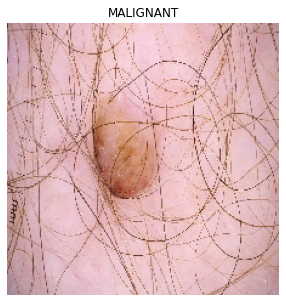

In [96]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
score = score.numpy()
print("% BENIGN", score[0])
print("% MALIGNANT", score[1])

finding = "BENIGN"
if score[0] < score[1]:
    finding = "MALIGNANT"

plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title(finding)
plt.axis("off")

In [97]:
data=[]
for i in tqdm(range(test_df.shape[0])):
    image_path = test_df.iloc[i].image_path
    image_name = image_path.replace("../input/siim-isic-melanoma-classification/jpeg/test/", "")
    target = get_prediction(image_path)
    data.append([image_name, target])

sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
sub_df.to_csv("./" + timestamp + "-submission.csv")

sub_df.head()

100%|██████████| 500/500 [01:48<00:00,  4.62it/s]


,image_name,target
0,data/test/ISIC_0052060.png,0.608887
1,data/test/ISIC_0052349.png,0.608887
2,data/test/ISIC_0058510.png,0.608887
3,data/test/ISIC_0073313.png,0.608887
4,data/test/ISIC_0073502.png,0.608887
